# Occlusion Sensitivity

This notebook conducts an experiment for the occlusion sensitivity of our networks.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%cd ..
%load_ext autoreload
%autoreload 2

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
# Load some packages
import os
from copy import deepcopy
import hydra
from collections import OrderedDict
import glob

import numpy as np
import pandas as pd
from cycler import cycler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchaudio
from torch.utils.data import DataLoader

import pprint
from tqdm.auto import tqdm
import wandb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDirectionArrows
from matplotlib.colors import Normalize

# custom package
from datasets.caueeg_script import build_dataset_for_train
from datasets.pipeline import EegSpectrogram
from datasets.pipeline import eeg_collate_fn
import models

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.12.1+cu113
cuda is available.


-----

## Load a trained model

In [4]:
model_name = 'lo88puq7'

# load from disk
try:
    path = os.path.join(r'E:\CAUEEG\checkpoint', model_name, 'checkpoint.pt')
    ckpt = torch.load(path, map_location=device)
except Exception as e:
    raise e

model_state = ckpt['model_state']
config = ckpt['config']

# initiate the model
if '_target_' in config:
    model = hydra.utils.instantiate(config).to(device)
elif type(config['generator']) is str:
    config['generator'] = getattr(models, config['generator'].split('.')[-1])
    if 'block' in config:
        config['block'] = getattr(models, config['block'].split('.')[-1])
    model = config['generator'](**config).to(device)
else:
    if 'block' in config:
        if config['block'] == models.resnet_1d.BottleneckBlock1D:
            config['block'] = 'bottleneck'
        elif config['block'] == models.resnet_2d.Bottleneck2D:
            config['block'] = 'bottleneck'
        elif config['block'] == models.resnet_1d.BasicBlock1D:
            config['block'] = 'basic'
        elif config['block'] == models.resnet_2d.BasicBlock2D:
            config['block'] = 'basic'

    model = config['generator'](**config).to(device)

if config.get('ddp', False):
    model_state_ddp = deepcopy(model_state)
    model_state = OrderedDict()
    for k, v in model_state_ddp.items():
        name = k[7:]  # remove 'module.' of DataParallel/DistributedDataParallel
        model_state[name] = v

model.load_state_dict(model_state)
model.requires_grad_(False)
model.eval()

print(f'{model_name} is successfully loaded.')

lo88puq7 is successfully loaded.


---

## Configurations

In [5]:
repeat = 3
minibatch = 1024
crop_multiple = 1
test_crop_multiple = 1
save_fig = True
target_dataset = 'val'  # train, test, val

In [6]:
config.pop('cwd', 0)
config['ddp'] = False
config['minibatch'] = 1
config['crop_multiple'] = crop_multiple
config['test_crop_multiple'] = test_crop_multiple
config['crop_timing_analysis'] = False
config['eval'] = True
config['device'] = device
H, W = config['seq_len_2d']

## Dataset

In [7]:
_ = build_dataset_for_train(config, verbose=False)
train_loader = _[0]
val_loader = _[1]
test_loader = _[2]
multicrop_test_loader = _[3]

if target_dataset == 'train':
    loader = train_loader
elif target_dataset == 'val':
    loader = val_loader
elif target_dataset == 'test':
    loader = test_loader
else:
    raise ValueError('')

## Helper functions

In [8]:
def estimate_score(model, sample_batched, config):
    # compute output embedding
    x = sample_batched['signal']
    age = sample_batched['age']
    output = model.compute_feature_embedding(x, age)
    
    if config['criterion'] == 'cross-entropy':
        s = F.softmax(output, dim=1)
    elif config['criterion'] == 'multi-bce':
        s = torch.sigmoid(output)
    elif config['criterion'] == 'svm':
        s = output

    # map depending on the loss function
    if config['criterion'] == 'cross-entropy':
        score = F.softmax(output, dim=1)
    elif config['criterion'] == 'multi-bce':
        score = torch.sigmoid(output)
    elif config['criterion'] == 'svm':
        score = output
    else:
        raise ValueError(f"estimate_score(): cannot parse config['criterion']={config['criterion']}.")
    return score

In [9]:
def from_as_real_to_complex(signal):
    N, _, H, W = signal.shape
    C = signal.shape[1] // 2

    sig_out = torch.zeros((N, C, H, W, 2))
    sig_out[..., 0] = signal[:, :C]
    sig_out[..., 1] = signal[:, C:]

    sig_out = torch.view_as_complex(sig_out)
    return sig_out

In [10]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# plt.style.use('fast') # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet' # 'jet', 'nipy_spectral', 'rainbow'

# plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'font.family': 'Arial'})
# plt.rcParams["font.family"] = 'DejaVu Sans' # 'NanumGothic' # for Hangul in Windows
plt.rcParams["savefig.dpi"] = 1200


def draw_stft(sample, config, index=0, log_scale=False, occlusion=None, save_fig=None):
    signal = deepcopy(sample['signal'])
    signal_f = from_as_real_to_complex(signal)[index].abs().cpu().numpy()
    
    # always do not consider EKG and Photic channels
    C = 19 # signal_f.shape[0]
    _, H, W = signal_f.shape
    
    columns = 7
    rows = round(np.ceil(C / columns))
    
    fig, ax = plt.subplots(rows, columns, 
                           figsize=(22.0, 9.5), constrained_layout=True)
    normalizer = Normalize()
    
    for k in range(columns * rows):
        r = k // columns
        c = k % columns
        
        if k < C:
            im = ax[r, c].imshow(np.log(signal_f[k, ::-1] + 1e-8) if log_scale else signal_f[k, ::-1],
                                 interpolation='nearest',
                                 extent=[0, config['seq_length']/200.0, 0, 200/2.0], 
                                 aspect=(config['seq_length']/200.0) / (200/2.0), norm=normalizer)
            ax[r, c].set_title(config['signal_header'][k].split('-')[0], 
                               fontsize=18, fontweight='bold', color='darkred')
            ax[r, c].set_xlabel('Time (s)', fontsize=13)
            ax[r, c].set_ylabel('Frequency (Hz)', fontsize=13)
            # ax[r, c].invert_yaxis()
            
            if occlusion and occlusion['c'] == k:
                bb = mtransforms.Bbox([[occlusion['x'] / W * config['seq_length']/200.0, 
                                        occlusion['y'] / H * 200/2.0], 
                                       [(occlusion['x'] + occlusion['w']) / W * config['seq_length']/200.0, 
                                        (occlusion['y'] + occlusion['h']) / H * 200/2.0]])
                fancy = FancyBboxPatch(bb.p0, bb.width, bb.height, boxstyle="square,pad=0")
                fancy.set(edgecolor="none", facecolor="gray", zorder=10)
                ax[r, c].add_patch(fancy)
            
        elif k == C:
            ax[r, c].axis('off')
            axins = ax[r, c]
        else:
            ax[r, c].axis('off')
        
    fig.suptitle('Time-Frequency Representation', fontsize=20, fontweight='semibold')
    cax = inset_axes(axins,
                     width="10%",  # width = 10% of parent_bbox width
                     height="80%",  # height : 50%
                     loc='center',
                     bbox_to_anchor=(0., 0., 1, 1),
                     bbox_transform=axins.transAxes,
                     borderpad=0,
                     )
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), cax=cax)
    cbar.ax.set_xlabel('Magnitude in log-scale' if log_scale else 'Magnitude', fontsize=13) 
    if save_fig:
        fig.savefig(os.path.join(save_fig, 'draw_stft.pdf'), transparent=True)
    else:
        plt.show()
    fig.clear()
    plt.close(fig)
    
    
def draw_stft_origin(sample, config, index=0, log_scale=False, occlusion=None, save_fig=None):
    sample = deepcopy(sample)
    EegSpectrogram(**config['stft_params'])(sample)
    signal_f = from_as_real_to_complex(sample['signal'])[index].abs().cpu().numpy()
    
    # always do not consider EKG and Photic channels
    C = 19 # signal_f.shape[0]
    _, H, W = signal_f.shape
    
    columns = 7
    rows = round(np.ceil(C / columns))
    
    fig, ax = plt.subplots(rows, columns, 
                           figsize=(22.0, 9.5), constrained_layout=True)
    normalizer = Normalize()
    
    for k in range(columns * rows):
        r = k // columns
        c = k % columns
        
        if k < C:
            im = ax[r, c].imshow(np.log(signal_f[k, ::-1] + 1e-8) if log_scale else signal_f[k, ::-1],
                                 interpolation='nearest',
                                 extent=[0, config['seq_length']/200.0, 0, 200/2.0], 
                                 aspect=(config['seq_length']/200.0) / (200/2.0), norm=normalizer)
            ax[r, c].set_title(config['signal_header'][k].split('-')[0], 
                               fontsize=18, fontweight='bold', color='darkred')
            ax[r, c].set_xlabel('Time (s)', fontsize=13)
            ax[r, c].set_ylabel('Frequency (Hz)', fontsize=13)
            # ax[r, c].invert_yaxis()
            
            if occlusion and occlusion['c'] == k:
                bb = mtransforms.Bbox([[occlusion['x'] / W * config['seq_length']/200.0, 
                                        occlusion['y'] / H * 200/2.0], 
                                       [(occlusion['x'] + occlusion['w']) / W * config['seq_length']/200.0, 
                                        (occlusion['y'] + occlusion['h']) / H * 200/2.0]])
                fancy = FancyBboxPatch(bb.p0, bb.width, bb.height, boxstyle="square,pad=0")
                fancy.set(edgecolor="none", facecolor="gray", zorder=10)
                ax[r, c].add_patch(fancy)
            
        elif k == C:
            ax[r, c].axis('off')
            axins = ax[r, c]
        else:
            ax[r, c].axis('off')
        
    fig.suptitle('Time-Frequency Representation', fontsize=20, fontweight='semibold')
    cax = inset_axes(axins,
                     width="10%",  # width = 10% of parent_bbox width
                     height="80%",  # height : 50%
                     loc='center',
                     bbox_to_anchor=(0., 0., 1, 1),
                     bbox_transform=axins.transAxes,
                     borderpad=0,
                     )
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), cax=cax)
    cbar.ax.set_xlabel('Magnitude in log-scale' if log_scale else 'Magnitude', fontsize=13) 
    if save_fig:
        fig.savefig(os.path.join(save_fig, 'draw_stft_origin.pdf'), transparent=True)
    else:
        plt.show()
    fig.clear()
    plt.close(fig)
    
    
def draw_occlusion_sensitivity(occlusion_score, config, suptitle=None, save_fig=None):
    # always do not consider EKG and Photic channels
    C, H, W = occlusion_score.shape
    
    columns = 7
    rows = round(np.ceil(C / columns))
    
    fig, ax = plt.subplots(rows, columns, 
                           figsize=(22.0, 9.5), constrained_layout=True)
    normalizer = Normalize()  # (0, 1)

    for k in range(columns * rows):
        r = k // columns
        c = k % columns
        
        if k < C:
            im = ax[r, c].imshow(occlusion_score[k, ::-1], interpolation='nearest',
                                 extent=[0, config['seq_length']/200.0, 0, 200/2.0], 
                                 aspect=(config['seq_length']/200.0) / (200/2.0), norm=normalizer)
            ax[r, c].set_title(config['signal_header'][k].split('-')[0], 
                               fontsize=18, fontweight='bold', color='darkred')
            ax[r, c].set_xlabel('Time (s)', fontsize=13)
            ax[r, c].set_ylabel('Frequency (Hz)', fontsize=13)
            # ax[r, c].invert_yaxis()
        elif k == C:
            ax[r, c].axis('off')
            axins = ax[r, c]
        else:
            ax[r, c].axis('off')
    
    if suptitle is None:
        suptitle = 'Occlusion Sensitivity'
    fig.suptitle(suptitle, fontsize=20, fontweight='semibold')
    # colorbar
    cax = inset_axes(axins,
                     width="10%",  # width = 10% of parent_bbox width
                     height="80%",  # height : 50%
                     loc='center',
                     bbox_to_anchor=(0., 0., 1, 1),
                     bbox_transform=axins.transAxes,
                     borderpad=0,
                     )
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), cax=cax)
    cbar.ax.set_xlabel('True class score', fontsize=13)
    if save_fig:
        fig.savefig(os.path.join(save_fig, 'draw_occlusion_sensitivity.pdf'), transparent=True)
    else:
        plt.show()
    fig.clear()
    plt.close(fig)
    
    
def draw_occlusion_sensitivity_all_channels(occlusion_score, config, suptitle=None, save_fig=None):
    # always do not consider EKG and Photic channels
    H, W = occlusion_score.shape
    
    fig, ax = plt.subplots(1, 2, figsize=(6.5, 4.0), constrained_layout=True)
    im = ax[0].imshow(occlusion_score[::-1], interpolation='nearest',
                      extent=[0, config['seq_length']/200.0, 0, 200/2.0], 
                      aspect=(config['seq_length']/200.0) / (200/2.0))
    ax[0].set_xlabel('Time (s)', fontsize=13)
    ax[0].set_ylabel('Frequency (Hz)', fontsize=13)
    
    if suptitle is None:
        suptitle = 'Occlusion Sensitivity (All Channels)'
    fig.suptitle(suptitle, fontsize=20, fontweight='semibold')
    
    # colorbar
    ax[1].axis('off')    
    cax = inset_axes(ax[1],
                     width="10%",  # width = 10% of parent_bbox width
                     height="80%",  # height : 50%
                     loc='center',
                     bbox_to_anchor=(0., 0., 1, 1),
                     bbox_transform=ax[1].transAxes,
                     borderpad=0,
                     )
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), cax=cax, shrink=0.9)
    cbar.ax.set_xlabel('True class score', fontsize=13) 
    if save_fig:
        fig.savefig(os.path.join(save_fig, 'draw_occlusion_sensitivity_all_channels.pdf'), transparent=True)
    else:
        plt.show()
    fig.clear()
    plt.close(fig)

In [11]:
def generate_occlusion_sensitivity_map(occlusion_sensitivity):
    coeff = np.zeros((19, H, W))
    score = np.zeros((19, H, W))

    for result in occlusion_sensitivity:
        s = result['score']
        c = result['c']
        x = result['x']
        y = result['y']
        w = result['w']
        h = result['h']

        score[c, y:y+h, x:x+w] += s
        coeff[c, y:y+h, x:x+w] += 1

    score = score / coeff
    return score


def generate_occlusion_sensitivity_all_channels_map(occlusion_sensitivity):
    coeff = np.zeros((H, W))
    score = np.zeros((H, W))

    for result in occlusion_sensitivity:
        s = result['score']
        x = result['x']
        y = result['y']
        w = result['w']
        h = result['h']

        score[y:y+h, x:x+w] += s
        coeff[y:y+h, x:x+w] += 1

    score = score / coeff
    return score

## Run experiments

In [12]:
for sample in loader:
    sample_origin = deepcopy(sample)
    config['preprocess_test'](sample)

    occlusion_sensitivity = []
    occ_cycler = cycler(x=np.arange(W)) * cycler(y=np.arange(H)) * \
                cycler(w=[round(W/4)]) * cycler(h=[round(H/4)]) * \
                cycler(c=np.arange(19))

    sample_batched = []
    for occ in tqdm(occ_cycler):
        # boundary condition
        if W < occ['x'] + occ['w'] or H < occ['y'] + occ['h']:
            continue

        # occlude
        sb_temp = deepcopy(sample)
        sb_temp['occlusion'] = occ
        C = sb_temp['signal'].shape[1]
        sb_temp['signal'][:, [occ['c'], C//2 + occ['c']], 
                          occ['y']:occ['y'] + occ['h'], 
                          occ['x']:occ['x'] + occ['w']] = 0
        sample_batched.append(sb_temp)

        # test
        if len(sample_batched) == minibatch:
            N = len(sample_batched)
            sample_batched = eeg_collate_fn(sample_batched)
            sample_batched['signal'] = sample_batched['signal'].reshape(N, C, H, W)
            sample_batched['age'] = sample_batched['age'].reshape(N)
            sample_batched['class_label'] = sample_batched['class_label'].reshape(N)
            s = estimate_score(model, sample_batched, config)

            for i in range(N):
                result = {**sample_batched['occlusion'][i], 
                          'score': s[i, sample_batched['class_label'][i]].item()}
                occlusion_sensitivity.append(result)
            sample_batched = []

    # test
    if len(sample_batched) > 0:
        N = len(sample_batched)
        sample_batched = eeg_collate_fn(sample_batched)
        sample_batched['signal'] = sample_batched['signal'].reshape(N, C, H, W)
        sample_batched['age'] = sample_batched['age'].reshape(N)
        sample_batched['class_label'] = sample_batched['class_label'].reshape(N)
        s = estimate_score(model, sample_batched, config)

        for i in range(N):
            result = {**sample_batched['occlusion'][i], 
                      'score': s[i, sample_batched['class_label'][i]].item()}
            occlusion_sensitivity.append(result)
        sample_batched = []        

    break

  0%|          | 0/152190 [00:00<?, ?it/s]

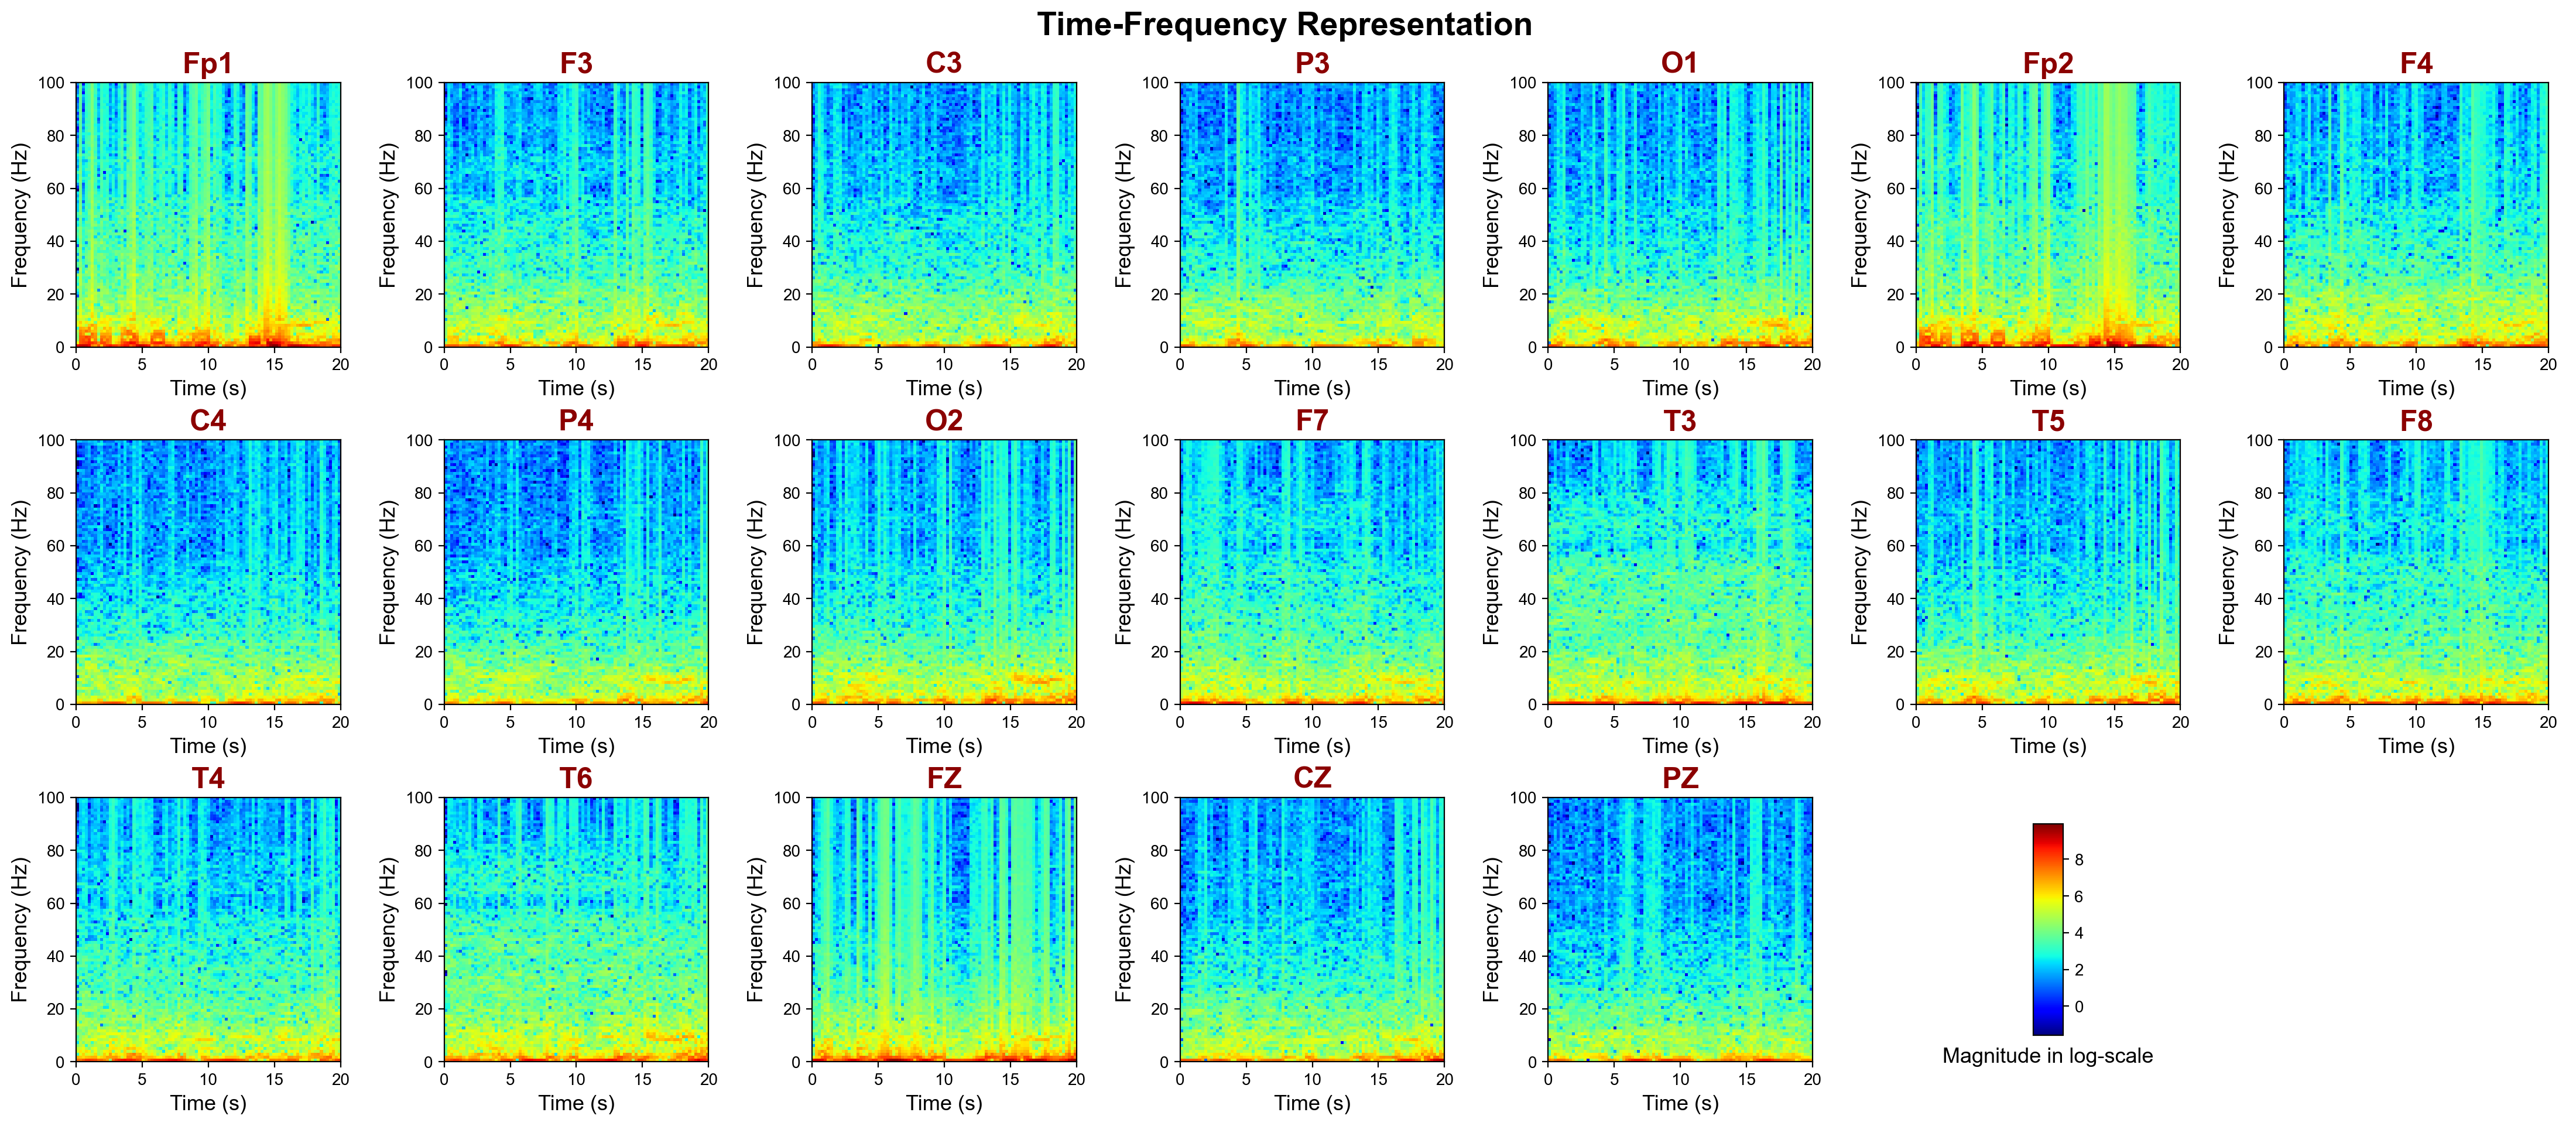

In [13]:
draw_stft_origin(sample_origin, config, log_scale=True)
# draw_stft_origin(sample_origin, config, log_scale=False)
# draw_stft(sample, config, log_scale=True)
# draw_stft(sample, config, log_scale=False)

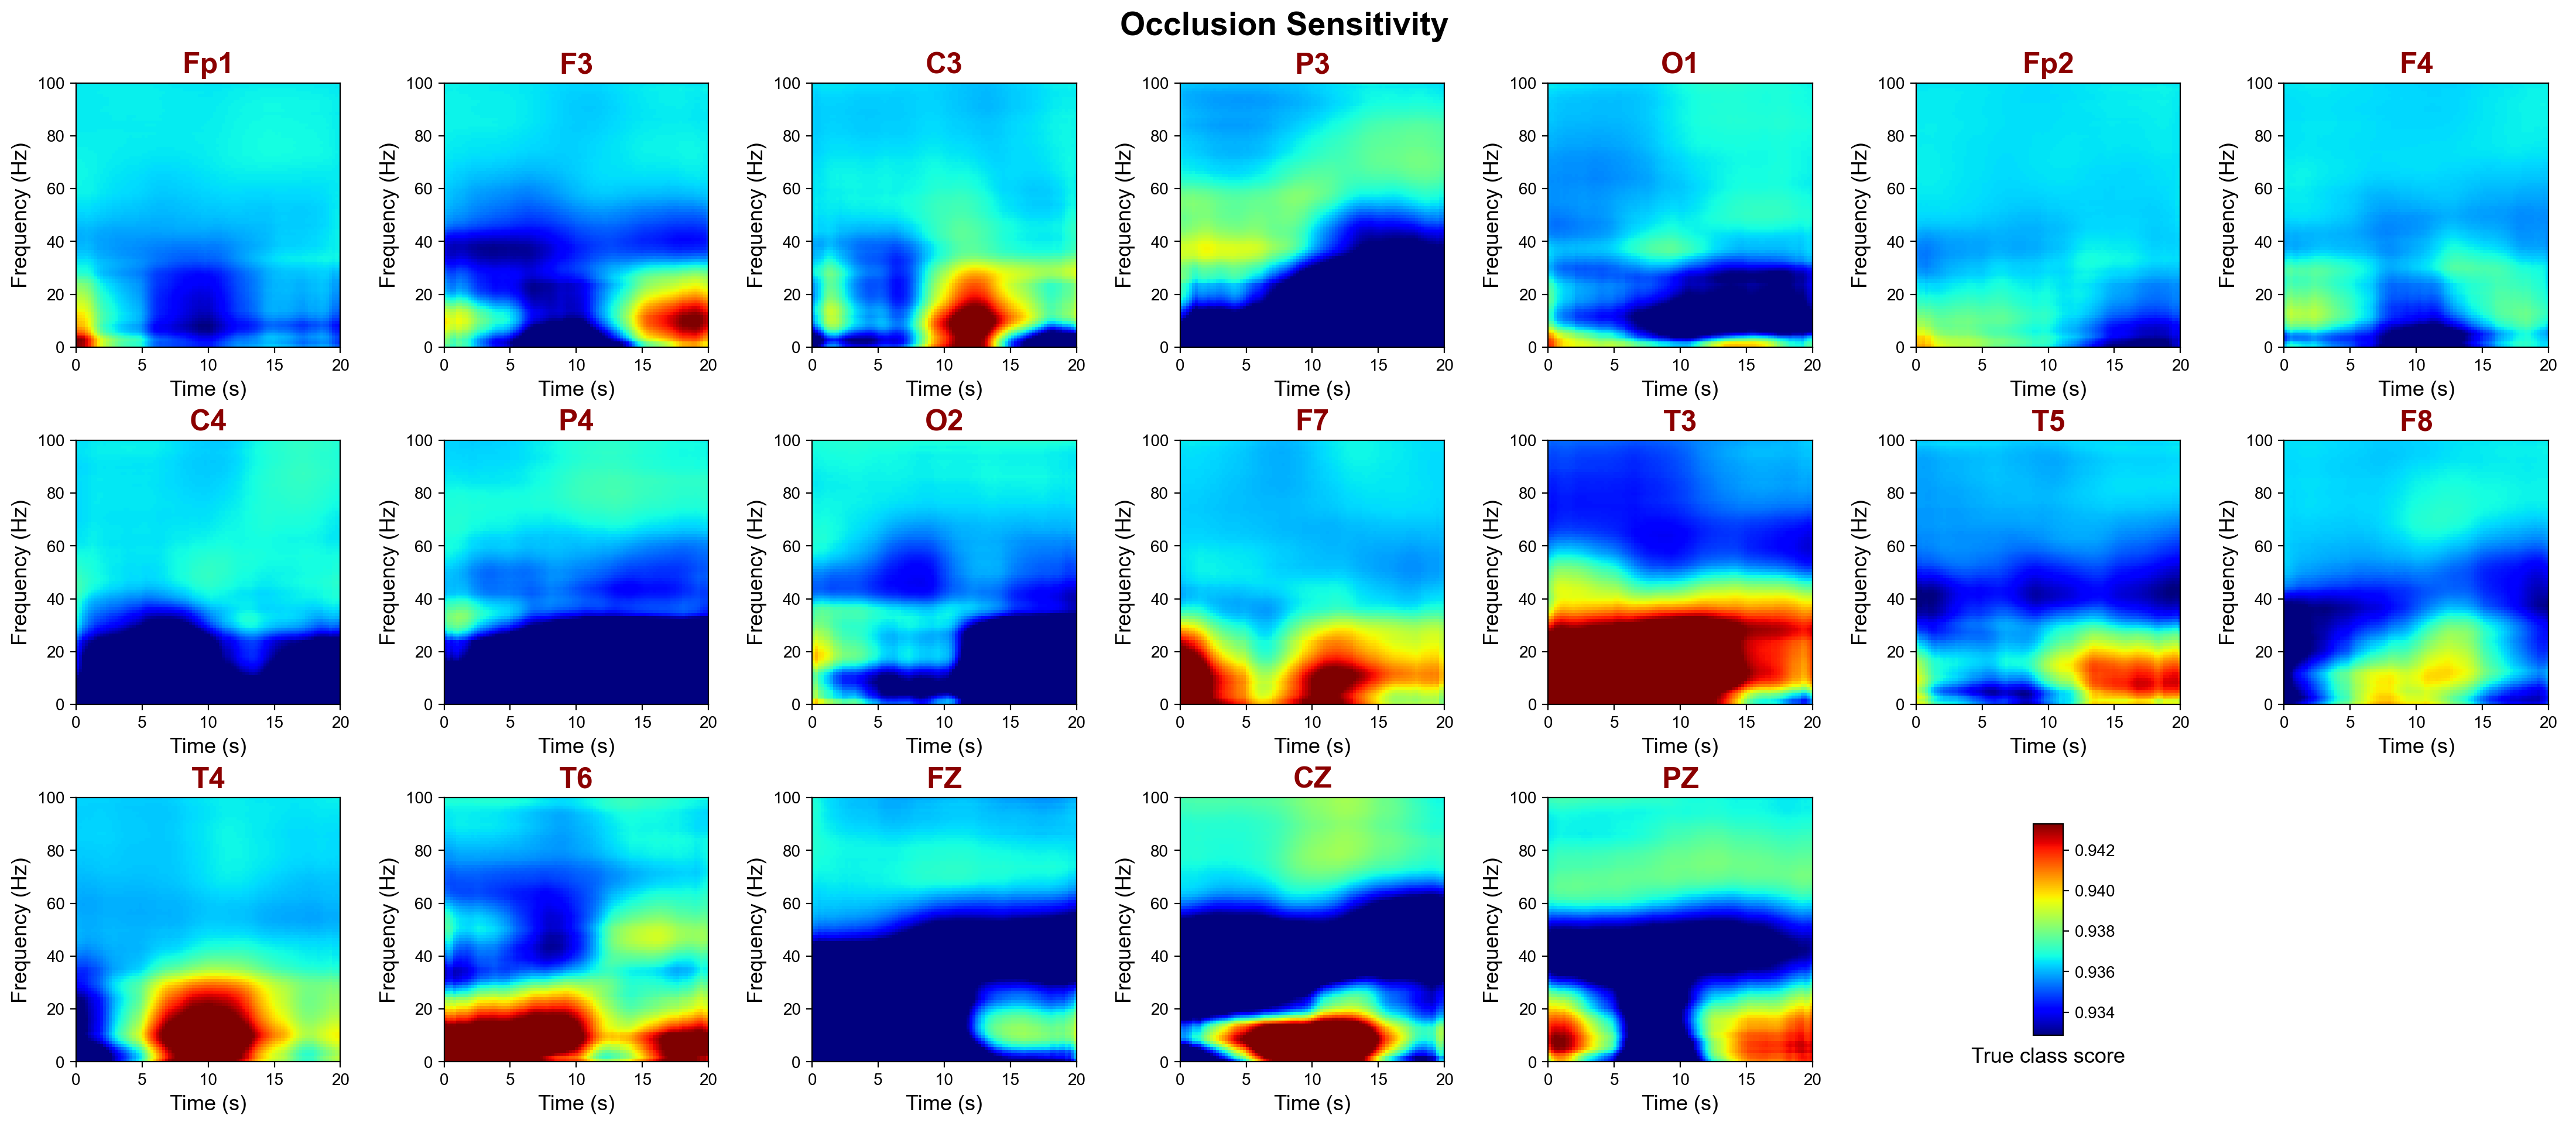

In [14]:
score = generate_occlusion_sensitivity_map(occlusion_sensitivity)
draw_occlusion_sensitivity(score, config)

In [15]:
occlusion_sensitivity_all_channels = []
occ_cycler = cycler(x=np.arange(W)) * cycler(y=np.arange(H)) * \
            cycler(w=[round(W/4)]) * cycler(h=[round(H/4)])

sample_batched = []
for occ in tqdm(occ_cycler):
    # boundary condition
    if W < occ['x'] + occ['w'] or H < occ['y'] + occ['h']:
        continue

    # occlude
    sb_temp = deepcopy(sample)
    sb_temp['occlusion'] = occ
    C = sb_temp['signal'].shape[1]
    sb_temp['signal'][:, :, 
                      occ['y']:occ['y'] + occ['h'], 
                      occ['x']:occ['x'] + occ['w']] = 0
    sample_batched.append(sb_temp)

    # test
    if len(sample_batched) == minibatch:
        N = len(sample_batched)
        sample_batched = eeg_collate_fn(sample_batched)
        sample_batched['signal'] = sample_batched['signal'].reshape(N, C, H, W)
        sample_batched['age'] = sample_batched['age'].reshape(N)
        sample_batched['class_label'] = sample_batched['class_label'].reshape(N)
        s = estimate_score(model, sample_batched, config)

        for i in range(N):
            result = {**sample_batched['occlusion'][i], 
                      'score': s[i, sample_batched['class_label'][i]].item()}
            occlusion_sensitivity_all_channels.append(result)
        sample_batched = []

# test
if len(sample_batched) > 0:
    N = len(sample_batched)
    sample_batched = eeg_collate_fn(sample_batched)
    sample_batched['signal'] = sample_batched['signal'].reshape(N, C, H, W)
    sample_batched['age'] = sample_batched['age'].reshape(N)
    sample_batched['class_label'] = sample_batched['class_label'].reshape(N)
    s = estimate_score(model, sample_batched, config)

    for i in range(N):
        result = {**sample_batched['occlusion'][i], 
                  'score': s[i, sample_batched['class_label'][i]].item()}
        occlusion_sensitivity_all_channels.append(result)
    sample_batched = []

  0%|          | 0/8010 [00:00<?, ?it/s]

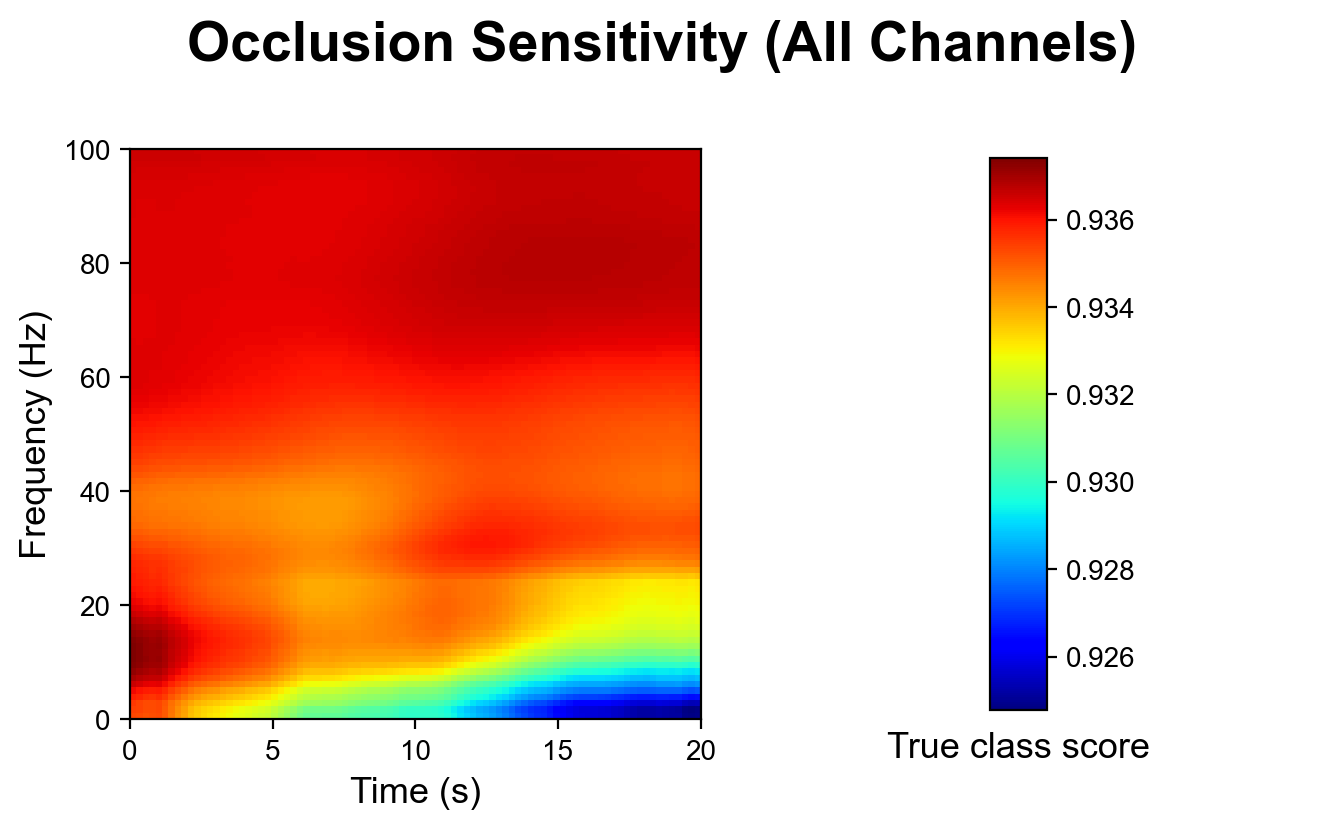

In [16]:
score = generate_occlusion_sensitivity_all_channels_map(occlusion_sensitivity)
draw_occlusion_sensitivity_all_channels(score, config)

## All pass

In [ ]:
for sample in tqdm(loader):
    sample_origin = deepcopy(sample)
    config['preprocess_test'](sample)

    occlusion_sensitivity = []
    occ_cycler = cycler(x=np.arange(W)) * cycler(y=np.arange(H)) * \
                cycler(w=[round(W/4)]) * cycler(h=[round(H/4)]) * \
                cycler(c=np.arange(19))

    sample_batched = []
    for occ in occ_cycler:
        # boundary condition
        if W < occ['x'] + occ['w'] or H < occ['y'] + occ['h']:
            continue

        # occlude and gather minibatch
        sb_temp = deepcopy(sample)
        sb_temp['occlusion'] = occ
        C = sb_temp['signal'].shape[1]
        sb_temp['signal'][:, [occ['c'], C//2 + occ['c']], 
                          occ['y']:occ['y'] + occ['h'], 
                          occ['x']:occ['x'] + occ['w']] = 0
        sample_batched.append(sb_temp)

        # test
        if len(sample_batched) == minibatch:
            N = len(sample_batched)
            sample_batched = eeg_collate_fn(sample_batched)
            sample_batched['signal'] = sample_batched['signal'].reshape(N, C, H, W)
            sample_batched['age'] = sample_batched['age'].reshape(N)
            sample_batched['class_label'] = sample_batched['class_label'].reshape(N)
            s = estimate_score(model, sample_batched, config)

            for i in range(N):
                result = {**sample_batched['occlusion'][i], 
                          'score': s[i, sample_batched['class_label'][i]].item()}
                occlusion_sensitivity.append(result)
            sample_batched = []

    # test
    if len(sample_batched) > 0:
        N = len(sample_batched)
        sample_batched = eeg_collate_fn(sample_batched)
        sample_batched['signal'] = sample_batched['signal'].reshape(N, C, H, W)
        sample_batched['age'] = sample_batched['age'].reshape(N)
        sample_batched['class_label'] = sample_batched['class_label'].reshape(N)
        s = estimate_score(model, sample_batched, config)

        for i in range(N):
            result = {**sample_batched['occlusion'][i], 
                      'score': s[i, sample_batched['class_label'][i]].item()}
            occlusion_sensitivity.append(result)
        sample_batched = []        


    # draw and save
    class_name = config['class_label_to_name'][sample["class_label"][0]]
    path = f'local/output/occlusion_exp/dementia/{target_dataset}/{class_name}/{sample["serial"][0]}'
    os.makedirs(path, exist_ok=True)
    draw_stft_origin(sample_origin, config, log_scale=True, save_fig=path)

    score = generate_occlusion_sensitivity_map(occlusion_sensitivity)
    with open(os.path.join(path, 'occlusion_sensitivity_map.npy'), 'wb') as f:
        np.save(f, score)
    draw_occlusion_sensitivity(score, config, save_fig=path)

    ################
    # All Channels #
    ################
    occlusion_sensitivity_all_channels = []
    occ_cycler = cycler(x=np.arange(W)) * cycler(y=np.arange(H)) * \
                cycler(w=[round(W/4)]) * cycler(h=[round(H/4)])

    sample_batched = []
    for occ in occ_cycler:
        # boundary condition
        if W < occ['x'] + occ['w'] or H < occ['y'] + occ['h']:
            continue

        # occlude and gather minibatch
        sb_temp = deepcopy(sample)
        sb_temp['occlusion'] = occ
        C = sb_temp['signal'].shape[1]
        sb_temp['signal'][:, :, 
                          occ['y']:occ['y'] + occ['h'], 
                          occ['x']:occ['x'] + occ['w']] = 0
        sample_batched.append(sb_temp)

        # test
        if len(sample_batched) == minibatch:
            N = len(sample_batched)
            sample_batched = eeg_collate_fn(sample_batched)
            sample_batched['signal'] = sample_batched['signal'].reshape(N, C, H, W)
            sample_batched['age'] = sample_batched['age'].reshape(N)
            sample_batched['class_label'] = sample_batched['class_label'].reshape(N)
            s = estimate_score(model, sample_batched, config)

            for i in range(N):
                result = {**sample_batched['occlusion'][i], 
                          'score': s[i, sample_batched['class_label'][i]].item()}
                occlusion_sensitivity_all_channels.append(result)
            sample_batched = []

    # test
    if len(sample_batched) > 0:
        N = len(sample_batched)
        sample_batched = eeg_collate_fn(sample_batched)
        sample_batched['signal'] = sample_batched['signal'].reshape(N, C, H, W)
        sample_batched['age'] = sample_batched['age'].reshape(N)
        sample_batched['class_label'] = sample_batched['class_label'].reshape(N)
        s = estimate_score(model, sample_batched, config)

        for i in range(N):
            result = {**sample_batched['occlusion'][i], 
                      'score': s[i, sample_batched['class_label'][i]].item()}
            occlusion_sensitivity_all_channels.append(result)
        sample_batched = []              

    score = generate_occlusion_sensitivity_all_channels_map(occlusion_sensitivity)
    with open(os.path.join(path, 'occlusion_sensitivity_all_channels_map.npy'), 'wb') as f:
        np.save(f, score)
    draw_occlusion_sensitivity_all_channels(score, config, save_fig=path)

  0%|          | 0/119 [00:00<?, ?it/s]

## Post analysis

In [ ]:
for target_dataset in ['train', 'test', 'val']:
    for root in glob.glob(f'local/output/occlusion_exp/dementia/{target_dataset}/*'):
        taget_class = os.path.basename(root)
        
        all_channel_count = 0
        count = 0
        
        for file in glob.glob(os.path.join(root, '*/*.npy')):
            if os.path.basename(file) == 'occlusion_sensitivity_map.npy':
                if count == 0:
                    occlusion_sensitivity_map = np.load(file)
                else:
                    occlusion_sensitivity_map += np.load(file)
                    
                count += 1
                
            elif os.path.basename(file) == 'occlusion_sensitivity_all_channels_map.npy':
                if all_channel_count == 0:
                    occlusion_sensitivity_all_channels_map = np.load(file)
                else:
                    occlusion_sensitivity_all_channels_map += np.load(file)
                
                all_channel_count += 1

            else:
                raise FileNotFoundError('')
    
        occlusion_sensitivity_all_channels_map = occlusion_sensitivity_all_channels_map / count
        occlusion_sensitivity_map = occlusion_sensitivity_map / count

        
        if target_dataset == 'train':
            dataset_name = 'Training Set'
        elif target_dataset == 'val':
            dataset_name = 'Validation Set'
        elif target_dataset == 'test':
            dataset_name = 'Test Set'
        
        save_path = f'local/output/occlusion_exp/dementia/{target_dataset}/{taget_class}/'
        os.makedirs(save_path, exist_ok=True)
        print(target_dataset, taget_class, count, all_channel_count, save_path)
        
        draw_occlusion_sensitivity(occlusion_sensitivity_map, config, save_fig=save_path,
                                   suptitle=f'Occlusion Sensitivity ({dataset_name}, {taget_class})')
        draw_occlusion_sensitivity_all_channels(occlusion_sensitivity_all_channels_map, config, save_fig=save_path,
                                                suptitle=f'Occlusion Sensitivity \n(All Channels, {dataset_name}, {taget_class})')
        
print('done')